In [1]:
import numpy as np
import pandas as pd
import os, sys
import glob
import tensorflow as tf
from tensorflow import keras
from scipy.fftpack import fft,ifft
import matplotlib.pyplot as plt
## Imports: Keras Models
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.models import Sequential, Model
from keras.layers import Cropping2D
from keras.layers.core import Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
import random
from sklearn.model_selection import train_test_split
from keras import metrics
### Imports: data preprocessing 
import csv
import numpy as np
import os
import sklearn
import keras.backend as K

sf = 250.
# Path for category 1
young_task_path = "/home/birdfly/Data/task/task young/"
# Path for category 2
young_non_task_path = "/home/birdfly/Data/task/non task young/"

freq_from = 0
freq_to = 20

channels_count = 26

Using TensorFlow backend.


In [2]:
def read_directory(young_task_path, young_non_task_path):
    # task_datas = []
    X_train = []
    y_train = []
    for sub_path in os.listdir(young_task_path):
        task_data_files_paths = glob.glob(os.path.join(young_task_path, sub_path) + "/*.csv")
        for task_data_files_path in task_data_files_paths:
            data = pd.read_csv(task_data_files_path, sep=',')
            data_req = transfer_time_to_freq(data)
            X_train.append(data_req)
            y_train.append(0)

    for sub_path in os.listdir(young_non_task_path):
        task_data_files_paths = glob.glob(os.path.join(young_non_task_path, sub_path) + "/*.csv")
        for task_data_files_path in task_data_files_paths:
            data = pd.read_csv(task_data_files_path, sep=',')
            data_req = transfer_time_to_freq(data)
            X_train.append(data_req)
            y_train.append(1)
            
    X_train = np.asarray(X_train)
    y_train = tf.keras.utils.to_categorical(y=y_train, num_classes=2)
    
    return X_train, y_train

In [3]:
def transfer_time_to_freq(data, freq_from = freq_from, freq_to = freq_to):
    freq_data = []
    for row_index in data:  
        fft_y=fft(data[row_index])
        T = 1/250.  # sampling interval 
        N = data[row_index].size
        # 1/T = frequency
        f = np.linspace(0, 1 / T, N)
        freq_data_row = np.abs(fft_y)[:N // 2] * 1 / N
        freq_data.extend(freq_data_row[freq_from:freq_to])
    
    freq_data_t = pd.DataFrame(freq_data).T.values.tolist()
    return freq_data

In [4]:
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2*((precision_m*recall_m)/(precision_m+recall_m+K.epsilon()))

In [50]:
def run_model(x_train, y_train, x_test, y_test):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense((freq_to - freq_from)*channels_count, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(max(freq_to - freq_from,channels_count), activation='relu'), 
        tf.keras.layers.Dense(min(freq_to - freq_from,channels_count), activation='relu'),     
        tf.keras.layers.Dense(2, activation='sigmoid')
    ])

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy', 
                                                         tf.keras.metrics.AUC(name='AUC'),
                                                         tf.keras.metrics.TruePositives(name='TP'),
                                                         tf.keras.metrics.TrueNegatives(name='TN'),                                                         
                                                         tf.keras.metrics.FalsePositives(name='FP'),
                                                         tf.keras.metrics.FalseNegatives(name='FN'),
                                                         tf.keras.metrics.Recall(class_id=0,name='task_recall'),
                                                         tf.keras.metrics.Recall(class_id=1,name='non-task_recall'), 
                                                         tf.keras.metrics.Precision(class_id=0,name='task_precision'),
                                                         tf.keras.metrics.Precision(class_id=1,name='non-task_precision')])
    history = model.fit(x_train, y_train, epochs= 50)
    results = model.evaluate(x_test, y_test)
    print('test loss, test acc:', results)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    model.save('model.h5')
    print('model.h5 has been saved.')

In [51]:
run_model(x_train, y_train, x_test, y_test)

Train on 98151 samples
Epoch 1/50
98151/98151 [==============================] - 6s 59us/sample - loss: 0.2032 - accuracy: 0.6882 - AUC: 0.7549 - TP: 68327.0000 - TN: 66711.0000 - FP: 31440.0000 - FN: 29824.0000 - task_recall: 0.7224 - non-task_recall: 0.6671 - task_precision: 0.6958 - non-task_precision: 0.6722
Epoch 2/50
98151/98151 [==============================] - 5s 49us/sample - loss: 0.1572 - accuracy: 0.7701 - AUC: 0.8513 - TP: 75682.0000 - TN: 75448.0000 - FP: 22703.0000 - FN: 22469.0000 - task_recall: 0.7936 - non-task_recall: 0.7462 - task_precision: 0.7740 - non-task_precision: 0.7638
Epoch 3/50
98151/98151 [==============================] - 5s 49us/sample - loss: 0.1399 - accuracy: 0.7974 - AUC: 0.8808 - TP: 78317.0000 - TN: 78206.0000 - FP: 19945.0000 - FN: 19834.0000 - task_recall: 0.8170 - non-task_recall: 0.7768 - task_precision: 0.8010 - non-task_precision: 0.7925
Epoch 4/50
98151/98151 [==============================] - 5s 49us/sample - loss: 0.1266 - accuracy: 0.81

KeyboardInterrupt: 

Train on 98151 samples
Epoch 1/50
98151/98151 [==============================] - 5s 46us/sample - loss: 0.2055 - accuracy: 0.6948
Epoch 2/50
98151/98151 [==============================] - 4s 42us/sample - loss: 0.1544 - accuracy: 0.7751
Epoch 3/50
98151/98151 [==============================] - 4s 41us/sample - loss: 0.1378 - accuracy: 0.8030
Epoch 4/50
98151/98151 [==============================] - 4s 41us/sample - loss: 0.1251 - accuracy: 0.8249
Epoch 5/50
98151/98151 [==============================] - 4s 42us/sample - loss: 0.1171 - accuracy: 0.8379
Epoch 6/50
98151/98151 [==============================] - 4s 41us/sample - loss: 0.1095 - accuracy: 0.8500
Epoch 7/50
98151/98151 [==============================] - 4s 42us/sample - loss: 0.1036 - accuracy: 0.8591
Epoch 8/50
98151/98151 [==============================] - 4s 42us/sample - loss: 0.0973 - accuracy: 0.8677
Epoch 9/50
98151/98151 [==============================] - 4s 42us/sample - loss: 0.0925 - accuracy: 0.8748
Epoch 10/50
98

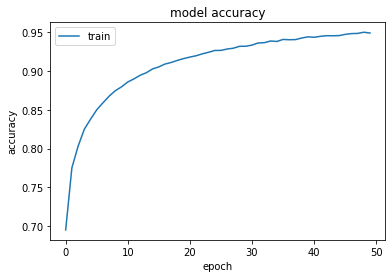

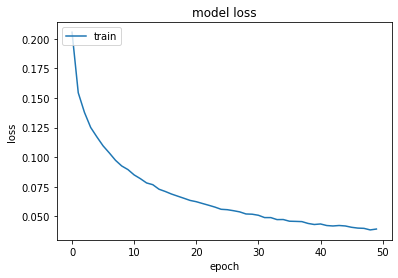

model.h5 has been saved.


In [6]:
if __name__ == "__main__":
    x, y = read_directory(young_task_path, young_non_task_path)
    
    x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

    run_model(x_train, y_train, x_test, y_test)

In [11]:
run_model(x_train, y_train, x_test, y_test)

Train on 98151 samples
Epoch 1/50
98151/98151 [==============================] - 5s 50us/sample - loss: 0.2055 - accuracy: 0.6909 - recall_3: 0.7260 - recall_4: 0.6485
Epoch 2/50
98151/98151 [==============================] - 4s 46us/sample - loss: 0.1567 - accuracy: 0.7703 - recall_3: 0.7938 - recall_4: 0.7468
Epoch 3/50
12352/98151 [==>...........................] - ETA: 3s - loss: 0.1440 - accuracy: 0.7927 - recall_3: 0.8150 - recall_4: 0.7716

KeyboardInterrupt: 

In [90]:
def test_result(x, model):
    result = model.predict(x)
    print(result)

In [91]:
def test_directory(task_path, model):
    for sub_path in os.listdir(young_task_path):
        task_data_files_paths = glob.glob(os.path.join(young_task_path, sub_path) + "/*.csv")
        for task_data_files_path in task_data_files_paths:
            data = pd.read_csv(task_data_files_path, sep=',')
            data_req = transfer_time_to_freq(data)
            print(task_data_files_path)
            test_result(np.asarray(data_req).reshape(1,-1), model)

In [ ]:
model = keras.models.load_model('model.h5')
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
test_directory(young_task_path, model)

/home/birdfly/Data/task/task young/2160202/POz884.csv
[[0.9834504  0.01642064]]
/home/birdfly/Data/task/task young/2160202/O1392.csv
[[1. 0.]]
/home/birdfly/Data/task/task young/2160202/F3147.csv
[[0.98525155 0.01470909]]
/home/birdfly/Data/task/task young/2160202/F4217.csv
[[1. 0.]]
/home/birdfly/Data/task/task young/2160202/TP91110.csv
[[1. 0.]]
/home/birdfly/Data/task/task young/2160202/T8598.csv
[[0.7873898  0.21243913]]
/home/birdfly/Data/task/task young/2160202/Oz923.csv
[[1. 0.]]
/home/birdfly/Data/task/task young/2160202/F7458.csv
[[1. 0.]]
/home/birdfly/Data/task/task young/2160202/P4341.csv
[[0.99138683 0.0087053 ]]
/home/birdfly/Data/task/task young/2160202/T8614.csv
[[9.9999738e-01 2.8235265e-06]]
/home/birdfly/Data/task/task young/2160202/F8488.csv
[[0.9939175  0.00601963]]
/home/birdfly/Data/task/task young/2160202/F3137.csv
[[0.9779335  0.02210089]]
/home/birdfly/Data/task/task young/2160202/TP91112.csv
[[9.9999678e-01 3.2524745e-06]]
/home/birdfly/Data/task/task young/2